In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

df = pd.read_csv('../data/processed/enriched_fraud_data.csv')

# Velocity Features 
df['device_usage_count'] = df.groupby('device_id')['device_id'].transform('count')
df['ip_usage_count'] = df.groupby('ip_address')['ip_address'].transform('count')


df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['time_to_purchase'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds()
df['hour_of_day'] = df['purchase_time'].dt.hour
df['day_of_week'] = df['purchase_time'].dt.dayofweek

features = [
    'purchase_value', 'age', 'time_to_purchase', 
    'device_usage_count', 'ip_usage_count', 
    'hour_of_day', 'day_of_week',
    'source', 'browser', 'sex', 'class'
]
df_filtered = df[features]

# Encoding Categorical Variables
df_encoded = pd.get_dummies(df_filtered, drop_first=True)

X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scaling is performed BEFORE SMOTE to ensure synthetic points are created in a normalized space
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle Class Imbalance with SMOTE 
print("--- Class Distribution Before SMOTE ---")
print(y_train.value_counts())

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("\n--- Class Distribution After SMOTE ---")
print(pd.Series(y_train_res).value_counts())

print(f"\nOriginal training shape: {X_train_scaled.shape}")
print(f"Resampled training shape: {X_train_res.shape}")

# Save the resampled data for the modeling task
X_train_res_df = pd.DataFrame(X_train_res, columns=X_train.columns)
y_train_res_df = pd.Series(y_train_res, name='class')

# Save resampled training data
X_train_res_df.to_csv('../data/processed/X_train_resampled.csv', index=False)
y_train_res_df.to_csv('../data/processed/y_train_resampled.csv', index=False)

# Save the scaled test data 
pd.DataFrame(X_test_scaled, columns=X_train.columns).to_csv('../data/processed/X_test_scaled.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

--- Class Distribution Before SMOTE ---
class
0    109568
1     11321
Name: count, dtype: int64

--- Class Distribution After SMOTE ---
class
0    109568
1    109568
Name: count, dtype: int64

Original training shape: (120889, 14)
Resampled training shape: (219136, 14)


Number of features after encoding: 14


C:\Users\a_kas\AppData\Local\Temp\ipykernel_2196\324039574.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, ax=axes[0], palette='viridis')
C:\Users\a_kas\AppData\Local\Temp\ipykernel_2196\324039574.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_res, ax=axes[1], palette='viridis')


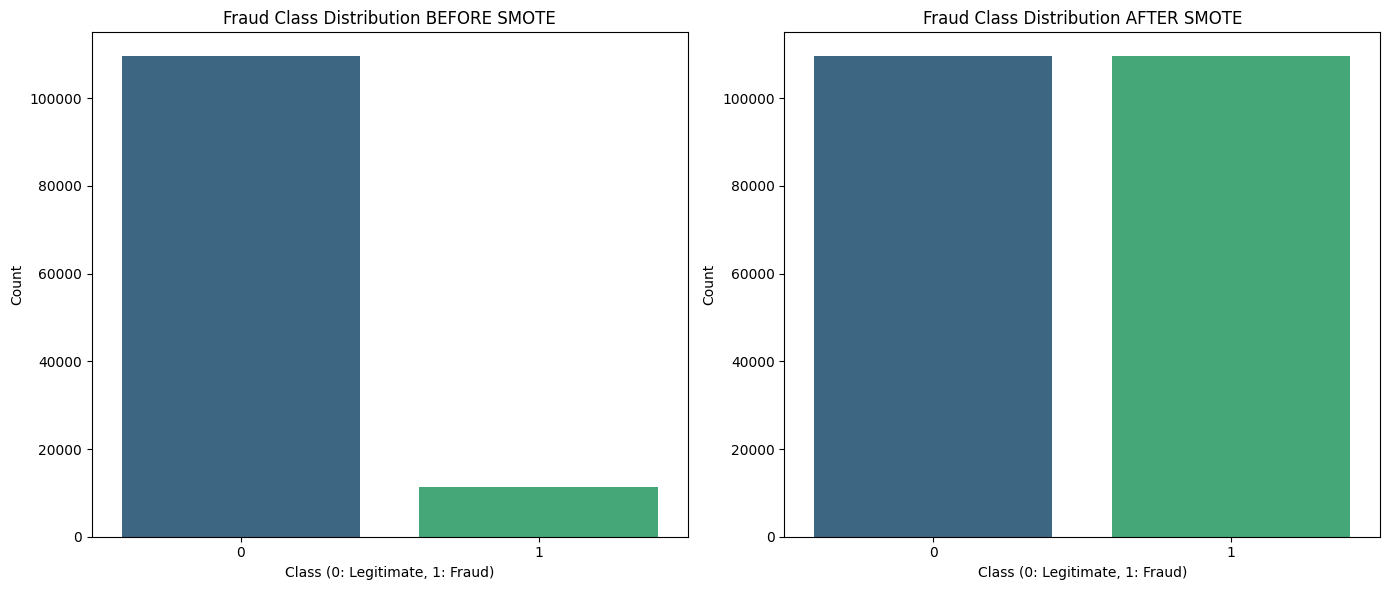

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Before SMOTE
sns.countplot(x=y_train, ax=axes[0], palette='viridis')
axes[0].set_title('Fraud Class Distribution BEFORE SMOTE')
axes[0].set_xlabel('Class (0: Legitimate, 1: Fraud)')
axes[0].set_ylabel('Count')

# Plot 2: After SMOTE
sns.countplot(x=y_train_res, ax=axes[1], palette='viridis')
axes[1].set_title('Fraud Class Distribution AFTER SMOTE')
axes[1].set_xlabel('Class (0: Legitimate, 1: Fraud)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()